In [1]:
from app.glance import Corpus, glance_at
from app.storage import data_from_tensor
from transformers import GPT2Tokenizer
from matplotlib import pyplot as plt
import torch
import torch.nn.functional as F
import json
from app.assess import llm_assessment


/Users/plato/code/sae_peek/v/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
c = Corpus('data/aesop-all')
top_samples = c.load_top_samples()
pile = Corpus('data/pile10k-all')

stat = "mean"

# delta = (c.stats['max_activations'][0] - pile.stats['max_activations'][0] + 1e-7) / (c.stats['max_activations'][0] + 1e-7) * (c.stats['max_activations'][0] != 0 * 1)
delta = (c.stats[stat] - pile.stats[stat] + 1e-7) / (c.stats[stat] + 1e-7) * (c.stats[stat] != 0 * 1)

topk = 32
topk_values, topk_indices = torch.topk(delta, topk)

In [10]:
print(topk_values)
print(topk_indices)

tensor([0.9962, 0.9948, 0.9937, 0.9937, 0.9929, 0.9925, 0.9922, 0.9918, 0.9908,
        0.9898, 0.9894, 0.9894, 0.9890, 0.9883, 0.9883, 0.9872, 0.9869, 0.9869,
        0.9867, 0.9865, 0.9861, 0.9861, 0.9860, 0.9859, 0.9857, 0.9856, 0.9856,
        0.9853, 0.9846, 0.9845, 0.9844, 0.9840])
tensor([18819, 19751, 22181,  7491,  9781,   740,  4448, 15539, 24329,  2697,
        12045,  9790, 24452, 18402,  6225,   558,  7839, 14392,  4682, 17810,
         5640,  1649, 18030, 15766, 17295, 11933,   193,  7016, 14856, 10843,
        20049,  2768])


In [12]:
a = Corpus('data/aesop-32-mean')
attention_mask, _, acts = a.load_all_data()


acts = acts * attention_mask
acts = acts[:, :514, :]
attention_mask = attention_mask[:, :514, :]
normalized_acts = acts / (torch.amax(acts, dim=(0, 1)) + 1e-8)

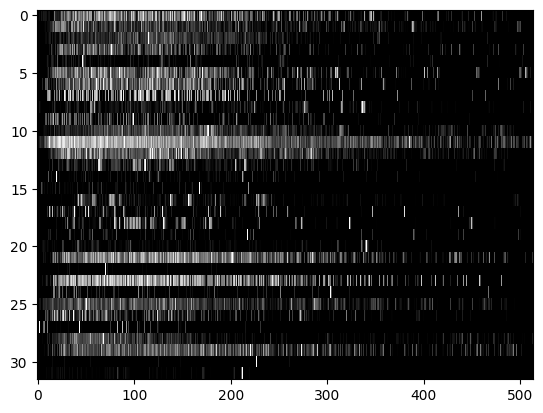

In [6]:
plt.imshow(torch.max(normalized_acts, dim=0)[0].T, cmap='gray', aspect='auto', interpolation="nearest")

In [14]:
def stretch_activations(activations, attention_mask):
    n_samples, seq_len, n_features = activations.shape
    max_len = attention_mask.sum(dim=1).max().item()  # Get the maximum non-padded length

    stretched_activations = torch.zeros((n_samples, max_len, n_features), device=activations.device)
    
    for i in range(n_samples):
        non_padded_len = attention_mask[i].sum().item()  # Find the actual length of each sequence
        if non_padded_len == 0:
            continue

        # Get the sequence without padding
        seq = activations[i, :non_padded_len].unsqueeze(0).permute(0, 2, 1)  # Shape: 1 x n_features x non_padded_len

        # Interpolate the sequence
        stretched_seq = F.interpolate(seq, size=(max_len,), mode='linear', align_corners=False)

        stretched_activations[i] = stretched_seq.squeeze(0).permute(1, 0)  # Shape: max_len x n_features
    
    return stretched_activations

In [15]:
s = stretch_activations(normalized_acts, attention_mask.to(torch.int))

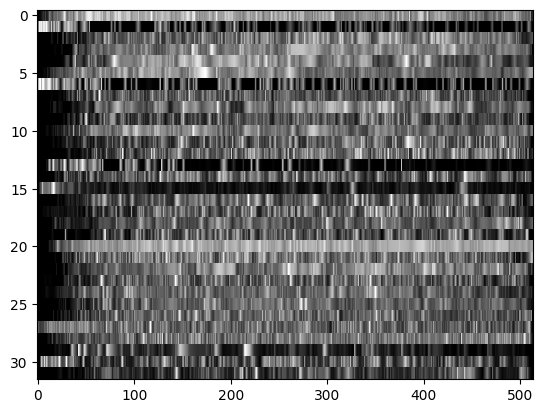

In [16]:
plt.imshow(torch.max(s, dim=0)[0].T, cmap='gray', aspect='auto', interpolation="nearest")

In [19]:
assessment_file = 'cruft/pile10k-all-mean.json'
llm_assessment('data/pile10k-all', output=assessment_file, samples_per_feature=10, relative_feature_indices=topk_indices.tolist())
with open(assessment_file) as f:
    pile10k = json.load(f)

Getting human descriptions: 100%|██████████| 32/32 [00:07<00:00,  4.04it/s]


Error: Unterminated string starting at: line 3 column 26 (char 74) encountered for message, {
  "feature_name": "Uncertainty and Confusion",
  "feature_description": "The model detects tokens related to uncertainty, confusion, or lack of clarity, such as 'happening', 'know', 'what', 'going', 'on', 'happened', 'why', 'how', 'if', 'perhaps', 'seem', 'unsure', 'confused', 'uncertain', 'unknown', 'mystery', 'question', 'wonder', 'doubt', 'guess', 'assume', 'suppose', 'think', 'believe', 'feel', 'imagine', 'consider', 'ponder', 'speculate', 'suspect', 'wonder', 'guess', 'assume', 'suppose', 'think', 'believe', 'feel', 'imagine', 'consider', 'ponder', 'speculate', 'suspect', 'wonder', 'guess', 'assume', 'suppose', '


In [24]:
with open(assessment_file) as f:
    pile10k = json.load(f)

In [31]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

In [33]:
top_fts = []
explain = []
for i in topk_indices.tolist():
    for f in pile10k:
        if f['feature'] == i:
            if f['assessment'] is not None:
                top_fts.append(str(i) + " " + f['assessment']['feature_name'])
                explain.append(f['assessment']['feature_description'])
            else:
                top_fts.append("SKIPPED")
                explain.append("SKIPPED")

assert len(top_fts) == topk_indices.shape[0]

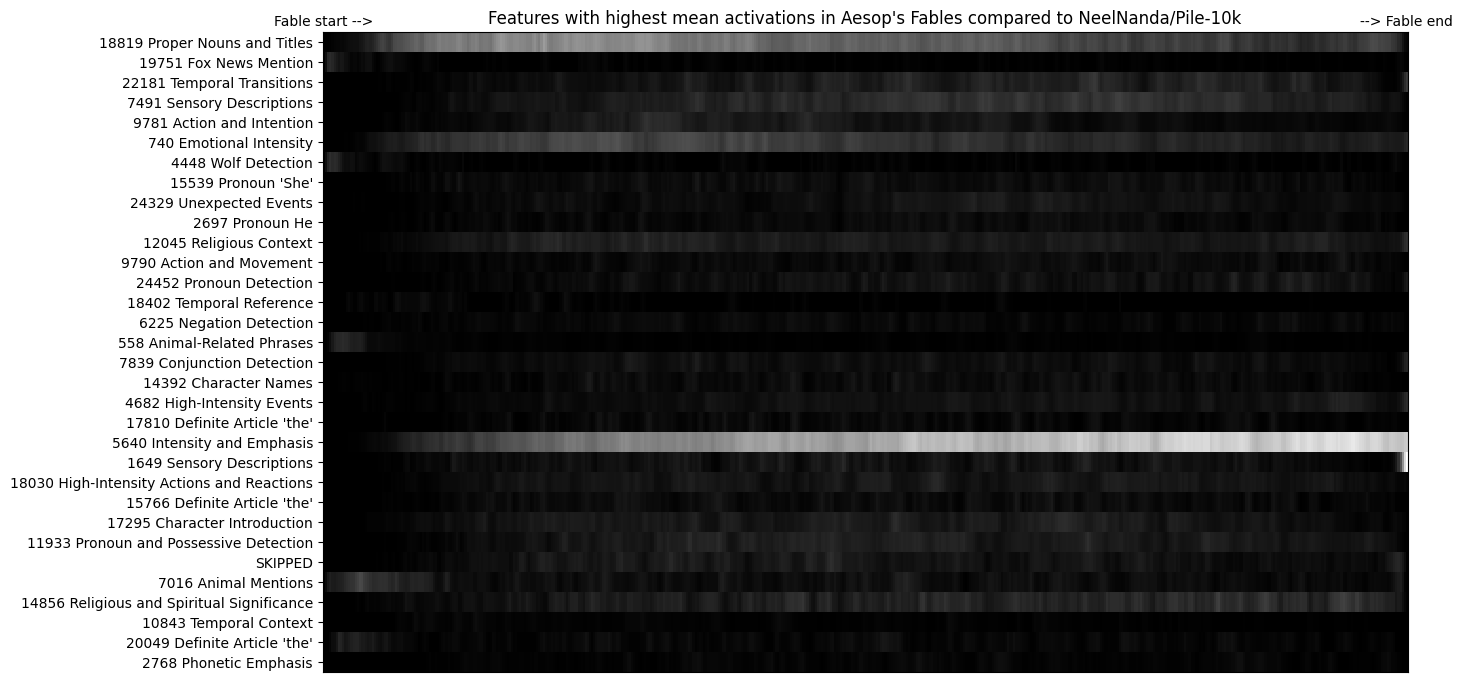

In [36]:
toplot = torch.mean(s, dim=0).T
# toplot = torch.max(s, dim=0)[0].T


plt.figure(figsize=(14, 8))

plt.imshow(toplot, cmap='gray', aspect='auto', interpolation="nearest")
plt.yticks(ticks=range(len(top_fts)), labels=top_fts)

plt.xticks([])
plt.title("Features with highest mean activations in Aesop's Fables compared to NeelNanda/Pile-10k")
# Add "start" and "end" labels
plt.text(0, -1, 'Fable start -->', ha='center', va='center', fontsize=10, color='black')
plt.text(toplot.shape[1] - 1, -1,  '--> Fable end', ha='center', va='center', fontsize=10, color='black')

plt.subplots_adjust(top=0.95, bottom=0.15)
# Show the plot
plt.show()

In [45]:
q = pile.by_relative_idx(topk_indices)
w = c.by_relative_idx(topk_indices)

for i, feature in enumerate(w):
    del feature['stats']
    feature['llm_title'] = top_fts[i]
    feature['llm_description'] = explain[i]
    feature['samples'] = [{'tokens': a.tolist(), 'activations': b.tolist()} for a, b in feature['samples']]

with open('cruft/aesop-activations.json', 'w') as f:
    json.dump(w, f, indent=4)

for i, feature in enumerate(q):
    del feature['stats']
    feature['llm_title'] = top_fts[i]
    feature['llm_description'] = explain[i]
    feature['samples'] = [{'tokens': a.tolist(), 'activations': b.tolist()} for a, b in feature['samples']]

with open('cruft/neelnanda-pile10k-activations.json', 'w') as f:
    json.dump(w, f, indent=4)

In [38]:
for i, feature in enumerate(w):
    print('---------', top_fts[i], '---------')
    print(explain[i])
    
    for tokens, token_acts in feature['samples']:
        try:
            glance_at(tokens, token_acts, tokenizer)
        except:
            continue

--------- 18819 Proper Nouns and Titles ---------
The model detects proper nouns, titles, and specific names of people, places, and entities. This includes names of historical figures, locations, and titles such as 'King', 'Queen', 'Duke', etc.
England as a designated Grade Âł I listed building , 
.  Reb uilding took place in the later part of the 18 th Âł century ; this included new north and south chap els in the 17 70 s by William and Thomas Lum by of Lincoln .  The 
75 âĢĵ 77 , and the top two stages were added to 
17 85 .  A new west door , partial 
door , partial rebuilding of the a is les , 
is les , the chance l , and the cle rest ory , probably also date 
19 th Âł century as a m aus ole um for the D ukes of St Âł Al b ans .  The church 
restored in 1888 by the local architect W . Âł 
rest or ations included removing the gallery , re ordering the seating , and the addition 
and the addition of a new south porch .  
ave , a is les and cle rest ory have lead 
have lead roofs ; th

In [39]:
for i, feature in enumerate(w):
    print('---------', top_fts[i], '---------')
    print(explain[i])
    
    for tokens, token_acts in feature['samples']:
        try:
            glance_at(tokens, token_acts, tokenizer)
        except:
            continue

--------- 18819 Proper Nouns and Titles ---------
The model detects proper nouns, titles, and specific names of people, places, and entities. This includes names of historical figures, locations, and titles such as 'King', 'Queen', 'Duke', etc.
ice were always up in arms against each other . In every battle the We as els carried off the victory , as well as a large number of the M ice , which they ate for dinner next day . In despair the M ice called a council , and there it was decided that the Mouse army was always beaten because it had no leaders . So a large number of generals and commanders were appointed from among the most eminent M ice . To distinguish themselves from the soldiers in the ranks , the new leaders proudly bound on their heads lofty cre sts and or nam ents of feathers or straw . Then after long preparation of the Mouse army in all the arts of war , they sent a challenge to the We as els . The We as els accepted the challenge with eager ness , for they were always r

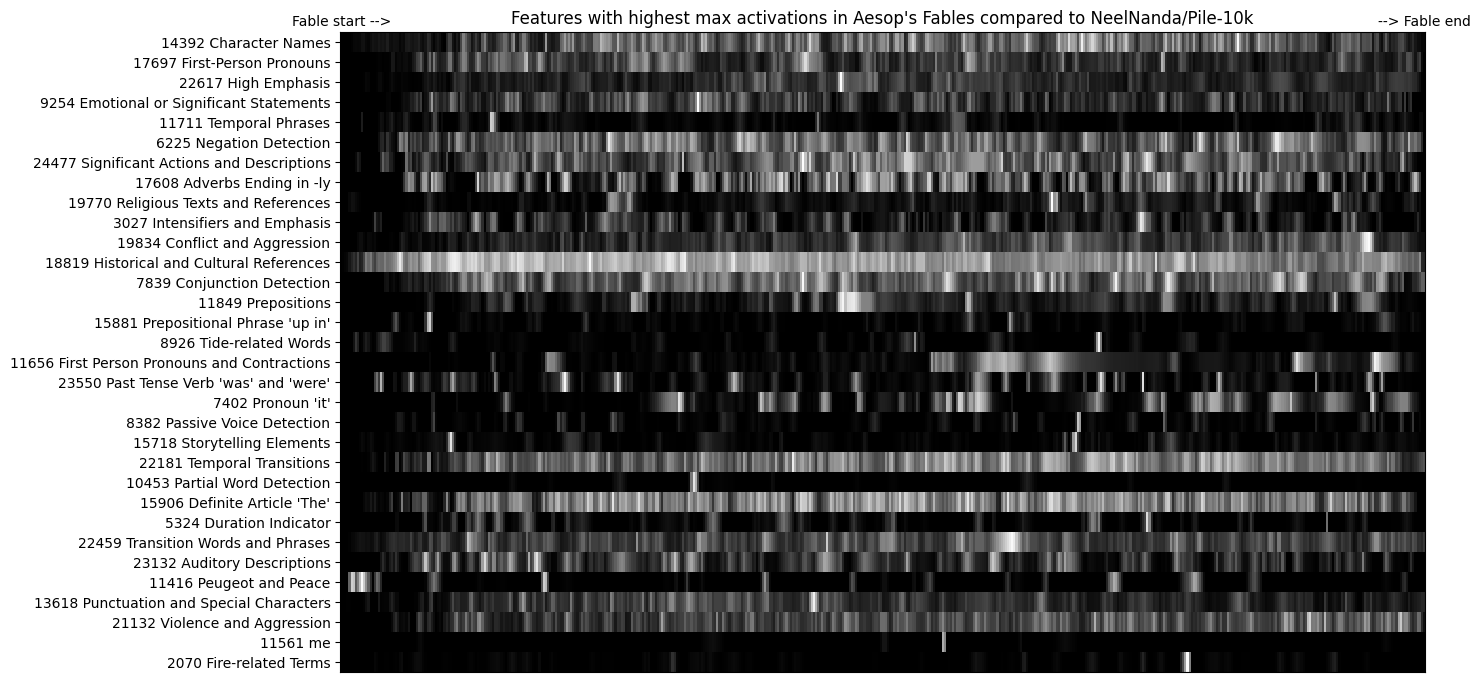

In [18]:
# toplot = torch.mean(s, dim=0).T
toplot = torch.max(s, dim=0)[0].T


plt.figure(figsize=(14, 8))

plt.imshow(toplot, cmap='gray', aspect='auto', interpolation="nearest")
plt.yticks(ticks=range(len(top_fts)), labels=top_fts)

plt.xticks([])
plt.title("Features with highest max activations in Aesop's Fables compared to NeelNanda/Pile-10k")
# Add "start" and "end" labels
plt.text(0, -1, 'Fable start -->', ha='center', va='center', fontsize=10, color='black')
plt.text(toplot.shape[1] - 1, -1,  '--> Fable end', ha='center', va='center', fontsize=10, color='black')

plt.subplots_adjust(top=0.95, bottom=0.15)
# Show the plot
plt.show()

In [21]:
w = c.by_relative_idx(topk_indices)

for i, feature in enumerate(w):
    print('---------', top_fts[i], '---------')
    print(explain[i])
    
    for tokens, token_acts in feature['samples']:
        try:
            glance_at(tokens, token_acts, tokenizer)
        except:
            continue

--------- 14392 Character Names ---------
The model detects proper nouns that are likely to be character names in the text. These include first names, last names, and sometimes titles or roles associated with individuals.
meeting of the Animals , who had gathered to elect 
a new ruler , the Monkey was asked to dance 
asked to dance . This he did so well , 
grim aces , that the Animals were carried entirely off 
off their feet with enthusiasm , and then and there , 
him their king . The Fox did not vote for the Monkey and was much disgusted with 
so unworthy a ruler . One day he found a 
. Hur rying to King Monkey , he told him he had 
a rich treasure , which he had not touched because 
majesty the Monkey . The greedy Monkey followed the Fox to the trap . 
as he saw the meat he grasped eagerly for it , only to find himself 
in the trap . The Fox stood off and laughed . You pretend to be our king 
, another election among the Animals was held . <|endoftext|> 
a shallow for d . They had c

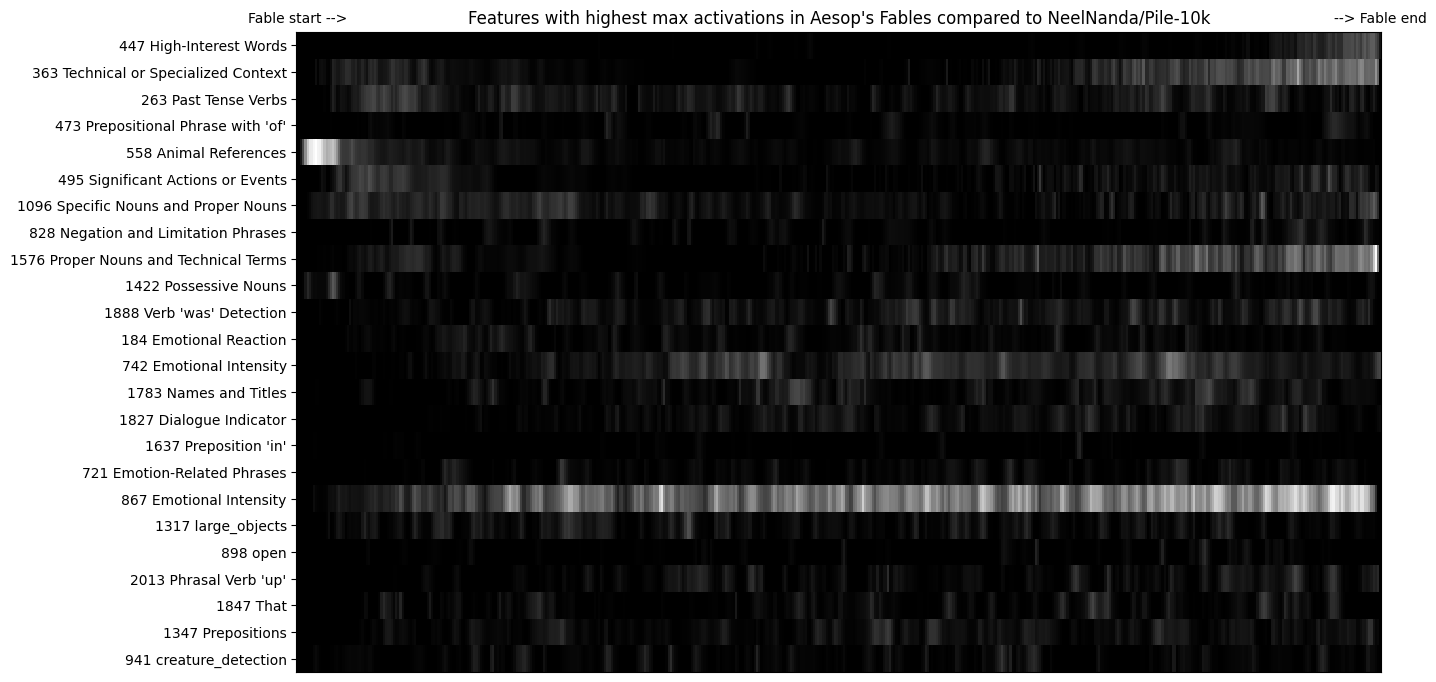

In [55]:
toplot = torch.mean(s[:, :, topk_indices], dim=0).T
# toplot = torch.max(s[:, :, topk_indices], dim=0)[0].T


plt.figure(figsize=(14, 8))

plt.imshow(toplot, cmap='gray', aspect='auto', interpolation="nearest")
plt.yticks(ticks=range(len(top_fts)), labels=top_fts)

plt.xticks([])
plt.title("Features with highest max activations in Aesop's Fables compared to NeelNanda/Pile-10k")
# Add "start" and "end" labels
plt.text(0, -1, 'Fable start -->', ha='center', va='center', fontsize=10, color='black')
plt.text(toplot.shape[1] - 1, -1,  '--> Fable end', ha='center', va='center', fontsize=10, color='black')

plt.subplots_adjust(top=0.95, bottom=0.15)
# Show the plot
plt.show()

In [52]:
w = c.by_relative_idx(topk_indices)

Loading samples from disk: 100%|██████████| 128/128 [00:02<00:00, 49.00it/s]


In [53]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

In [54]:
for i, feature in enumerate(w):
    print('---------', top_fts[i], '---------')
    print(explain[i])
    
    for tokens, token_acts in feature['samples']:
        try:
            glance_at(tokens, token_acts, tokenizer)
        except:
            continue

--------- 447 High-Interest Words ---------
The model detects words that are likely to be of high interest or importance in the context, such as company names, key terms, and emotionally charged words.
ailed and called on Mercury to help them . And 
And indeed , Mercury did appear , first to this one , then 
, then to that . To each one he showed an axe of gold , and each one eagerly claimed it to be the one he had lost . But Mercury did not give them the golden axe . Oh no ! Instead he gave them each a hard wh ack over the head with it and sent them home . And when they returned next day to look for their own axes , they were nowhere to be found . 
to do it , I admit - A great uproar among the beasts interrupted 
him . Here was the culprit who had brought misfortune on all of them 
of them ! What a horrible crime it was to eat grass that 
to someone else ! It was enough to hang anyone for , much more an Ass . Immediately they all fell upon him , the Wolf in the lead , and soon had mad